## init

In [2]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import mnist_utils as mu
from pathlib import Path
save_path = "/home/jloch/Desktop/diff/luzern/values_datasets/mnist"


## AU2 train/val acc

In [117]:
p = "/home/jloch/Desktop/diff/luzern/random_experiments/mnist/saves/channels"

df = pd.DataFrame(columns=["uncertainty","model","train_acc","test_acc","params"])

model_matches = ["MLP_", "CNN_"]
unc_matches_eq = ["AU2_EU"]

for filename in os.listdir(p):
    if filename.endswith(".pth"):
        file_path = os.path.join(p, filename)
        data = torch.load(file_path, weights_only=False)
        num_params = sum([v.numel() for v in data["checkpoints"][0].values()])
        unc_cfg,model_cfg = filename.replace(".pth","").split("__")
        n = len(data["checkpoints"])
        if not any([model_cfg.startswith(m) for m in model_matches]):
            continue
        if not any([m == unc_cfg for m in unc_matches_eq]):
            continue
        values = [unc_cfg,model_cfg, 
                [float(data["final_acc"][i]["train_acc"]) for i in range(n)], 
                [float(data["final_acc"][i]["test_acc"]) for i in range(n)], 
                num_params]
        df.loc[len(df)] = values
print(f"Found {len(df)} models")

Found 20 models


In [118]:


#print(seq_type_from_name("MLP_aug0.2_H"))
# Add all stats to df. Add new columns if needed.
for i, row in df.iterrows():
    params = mu.seq_type_from_name(row["model"])
    for k,v in params.items():
        if k not in df.columns:
            df[k] = None
        df.at[i,k] = v

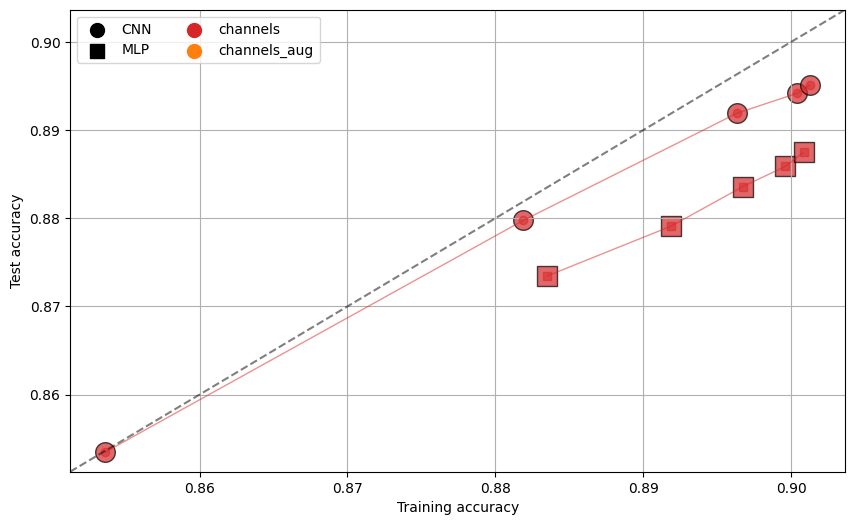

In [120]:
# colors differentiate seq_types
# symbols differentiate model types

uq_model_types = sorted(df["model_type"].unique().tolist())
uq_seq_types = sorted(df["seq_type"].unique().tolist())

#only_show_seq_type = uq_seq_types
only_show_seq_type = ["channels"]

add_text = False
show_means = True
connect_means = True

symbols = ["o", "s"]
cols = ["C3", "C1", "C2", "C0", "C4", "C5","C6"]
assert len(cols) >= len(uq_seq_types), f"Only {len(cols)} colors for {len(uq_seq_types)} sequence types"
assert len(symbols) >= len(uq_model_types), f"Only {len(symbols)} symbols for {len(uq_model_types)} model types"
plt.figure(figsize=(10,6))
for i,mt in enumerate(uq_model_types):
    for j,st in enumerate(uq_seq_types):
        if st not in only_show_seq_type:
            continue
        mask = (df["model_type"] == mt) & (df["seq_type"] == st)
        if np.sum(mask) == 0:
            continue
        sub_df = df[mask]
        assert len(set(sub_df["varying_param"])) == 1, f"Multiple varying params in {mt}, {st}. Found: {set(sub_df['varying_param'])}"

        # extract #[varying_param]x#[num_models] arrays for train_acc and test_acc
        train_accs = np.array(sub_df["train_acc"].tolist())
        test_accs = np.array(sub_df["test_acc"].tolist())
        param_name = sub_df["varying_param"].iloc[0]
        #expand to same size as train_accs/test_accs
        param_values = np.array(sub_df[param_name].tolist())[:,None].repeat(train_accs.shape[1], axis=1)
        
        if show_means:
            train_accs = train_accs.mean(axis=1)
            test_accs = test_accs.mean(axis=1)
            param_values = param_values.mean(axis=1)
            #sort by param_values
            sort_idx = np.argsort(param_values)
            train_accs = train_accs[sort_idx]
            test_accs = test_accs[sort_idx]
            param_values = param_values[sort_idx]
            if connect_means:
                #connect means with a line
                plt.plot(train_accs, test_accs, color=cols[j], marker=symbols[i], alpha=0.5, linewidth=1)
        plt.scatter(train_accs.flatten(), test_accs.flatten(),
                    color=cols[j], marker=symbols[i], s=200 if show_means else 100, alpha=0.7, edgecolor='k'
                )
        if add_text:
            # add param value as text in the center of each point
            param_values = param_values.astype(identifiers_inv[param_name][1])
            for k in range(len(train_accs.flatten())):
                s = str(param_values.flatten()[k])
                modif = 0.5+0.5/len(s)
                plt.text(train_accs.flatten()[k], test_accs.flatten()[k], s,
                        color='k', fontsize=12*modif, ha='center', va='center')
                

for j,model in enumerate(uq_model_types):
    plt.scatter([], [], color='k', marker=symbols[j], s=100, label=model)
for i,unc in enumerate(uq_seq_types):
    plt.scatter([], [], color=cols[i], marker='o', s=100, label=unc)
plt.xlabel("Training accuracy")
plt.ylabel("Test accuracy")
plt.legend(ncols=2)
#get current axis bounds
ax = plt.gca()
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
l1,l2 = min(x0,y0), max(x1,y1)
plt.plot([l1,l2],[l1,l2], 'k--', alpha=0.5)
plt.xlim(l1,l2), plt.ylim(l1,l2)
plt.grid()



## AU2 scatters

In [5]:
data.keys()

dict_keys(['checkpoints', 'histories', 'final_acc', 'uncertainty_setup', 'model_setup', 'unc_stats'])

In [39]:
# READ IN ALL AU2 DATA
p = "/home/jloch/Desktop/diff/luzern/random_experiments/mnist/saves"

df = pd.DataFrame()
model_matches = ["MLP_", "CNN_"]
unc_matches_eq = ["AU2_EU"]
folder_matches = None
folder_matches = ["epochs_H","aug_H","batch_size_H","batch_size_H_aug","epochs_lrd_H_ema","epochs_lrd_H"]
for filepath in Path(p).rglob("*.pth"):
    parent = filepath.parent.name
    if folder_matches is not None:
        if not any([m == parent for m in folder_matches]):
            continue
    filename = filepath.name
    unc_cfg,model_cfg = filename.replace(".pth","").split("__")
    
    if not any([model_cfg.startswith(m) for m in model_matches]):
        continue
    if not any([m == unc_cfg for m in unc_matches_eq]):
        continue
    data = torch.load(filepath, weights_only=False)
    n = len(data["checkpoints"])
    params = sum([v.numel() for v in data["checkpoints"][0].values()])
    unc_cfg,model_cfg = filename.replace(".pth","").split("__")
    value_dict = {"unc_cfg": unc_cfg, 
                "model_cfg": model_cfg,
                "model_setup": data["model_setup"],
                "seq_type": parent,
                "varying_param": mu.seq_type_to_varying_param[parent],
                "train_acc": sum([data["final_acc"][i]["train_acc"] for i in range(len(data["final_acc"]))]) / len(data["final_acc"]),
                "test_acc": sum([data["final_acc"][i]["test_acc"] for i in range(len(data["final_acc"]))]) / len(data["final_acc"]),
                "params": params,
                "EU_auc": data["unc_stats"]["ood_stats"]["EU"]["auc"],
                "AU_auc": data["unc_stats"]["ood_stats"]["AU"]["auc"],
                "TU_auc": data["unc_stats"]["ood_stats"]["TU"]["auc"],
                "EU_iid": data["unc_stats"]["ood_stats"]["EU"]["iid_entropy"],
                "EU_ood": data["unc_stats"]["ood_stats"]["EU"]["ood_entropy"],
                "AU_iid": data["unc_stats"]["ood_stats"]["AU"]["iid_entropy"],
                "AU_ood": data["unc_stats"]["ood_stats"]["AU"]["ood_entropy"],
                "TU_iid": data["unc_stats"]["ood_stats"]["TU"]["iid_entropy"],
                "TU_ood": data["unc_stats"]["ood_stats"]["TU"]["ood_entropy"],
                "TU_rankcorr": data["unc_stats"]["amb_stats"]["TU"]["spearman_all"],
                "EU_rankcorr": data["unc_stats"]["amb_stats"]["EU"]["spearman_all"],
                "AU_rankcorr": data["unc_stats"]["amb_stats"]["AU"]["spearman_all"],
                "mean_AU": data["unc_stats"]["amb_stats"]["TU"]["mean_entropies"]["all"],
                "mean_EU": data["unc_stats"]["amb_stats"]["EU"]["mean_entropies"]["all"],
                "mean_TU": data["unc_stats"]["amb_stats"]["AU"]["mean_entropies"]["all"],
                "TU_ece": data["unc_stats"]["calib_stats"]["TU"]["ece"],
                "AU_ece": data["unc_stats"]["calib_stats"]["AU"]["ece"],
                "EU_ece": data["unc_stats"]["calib_stats"]["EU"]["ece"],
                "TU_ace": data["unc_stats"]["calib_stats"]["TU"]["ace"],
                "AU_ace": data["unc_stats"]["calib_stats"]["AU"]["ace"],
                "EU_ace": data["unc_stats"]["calib_stats"]["EU"]["ace"],
                "TU_ncc": data["unc_stats"]["amb_stats"]["TU"]["ncc_all"],
                "AU_ncc": data["unc_stats"]["amb_stats"]["AU"]["ncc_all"],
                "EU_ncc": data["unc_stats"]["amb_stats"]["EU"]["ncc_all"],
                "sep_majority": np.mean(data["unc_stats"]["knn_sep"]["per_class_acc_majority"]),
                "sep_soft": np.mean(data["unc_stats"]["knn_sep"]["per_class_acc_soft"]),
                }
    value_dict["EU_iid/AU_iid"] = value_dict["EU_iid"] / value_dict["AU_iid"]
    value_dict["EU_ood/AU_ood"] = value_dict["EU_ood"] / value_dict["AU_ood"]
    if value_dict["model_setup"]["model"]=="models.CNNDeluxe":
        value_dict["depth"] = value_dict["model_setup"]["model_args"]["num_blocks"]
        value_dict["channels"] = value_dict["model_setup"]["model_args"]["base_channels"]
    elif value_dict["model_setup"]["model"]=="models.MLPDeluxe":
        value_dict["depth"] = value_dict["model_setup"]["model_args"]["num_layers"]
        value_dict["channels"] = value_dict["model_setup"]["model_args"]["width"]
    else:
        print(f"Unknown model {value_dict['model_setup']['model']}")
    for k,v in value_dict.items():
        if torch.is_tensor(v):
            value_dict[k] = float(v)
    if df.empty:
        df = pd.DataFrame(columns=list(value_dict.keys()))
    value_list = [value_dict[col] for col in df.columns]
    df.loc[len(df)] = value_list

#add all stats from model_setup to df, NaN if not present
all_keys = set(sum([list(d.keys()) for d in df["model_setup"]], []))
for k in all_keys:
    if k not in df.columns:
        df[k] = None
    for i, row in df.iterrows():
        if k in row["model_setup"]:
            df.at[i,k] = row["model_setup"][k]

print(f"Found {len(df)} models")


Found 140 models


In [13]:
df.seq_type.unique().tolist()

['aug_H',
 'batch_size_H',
 'batch_size_H_aug',
 'epochs_H',
 'epochs_lrd_H',
 'epochs_lrd_H_ema']

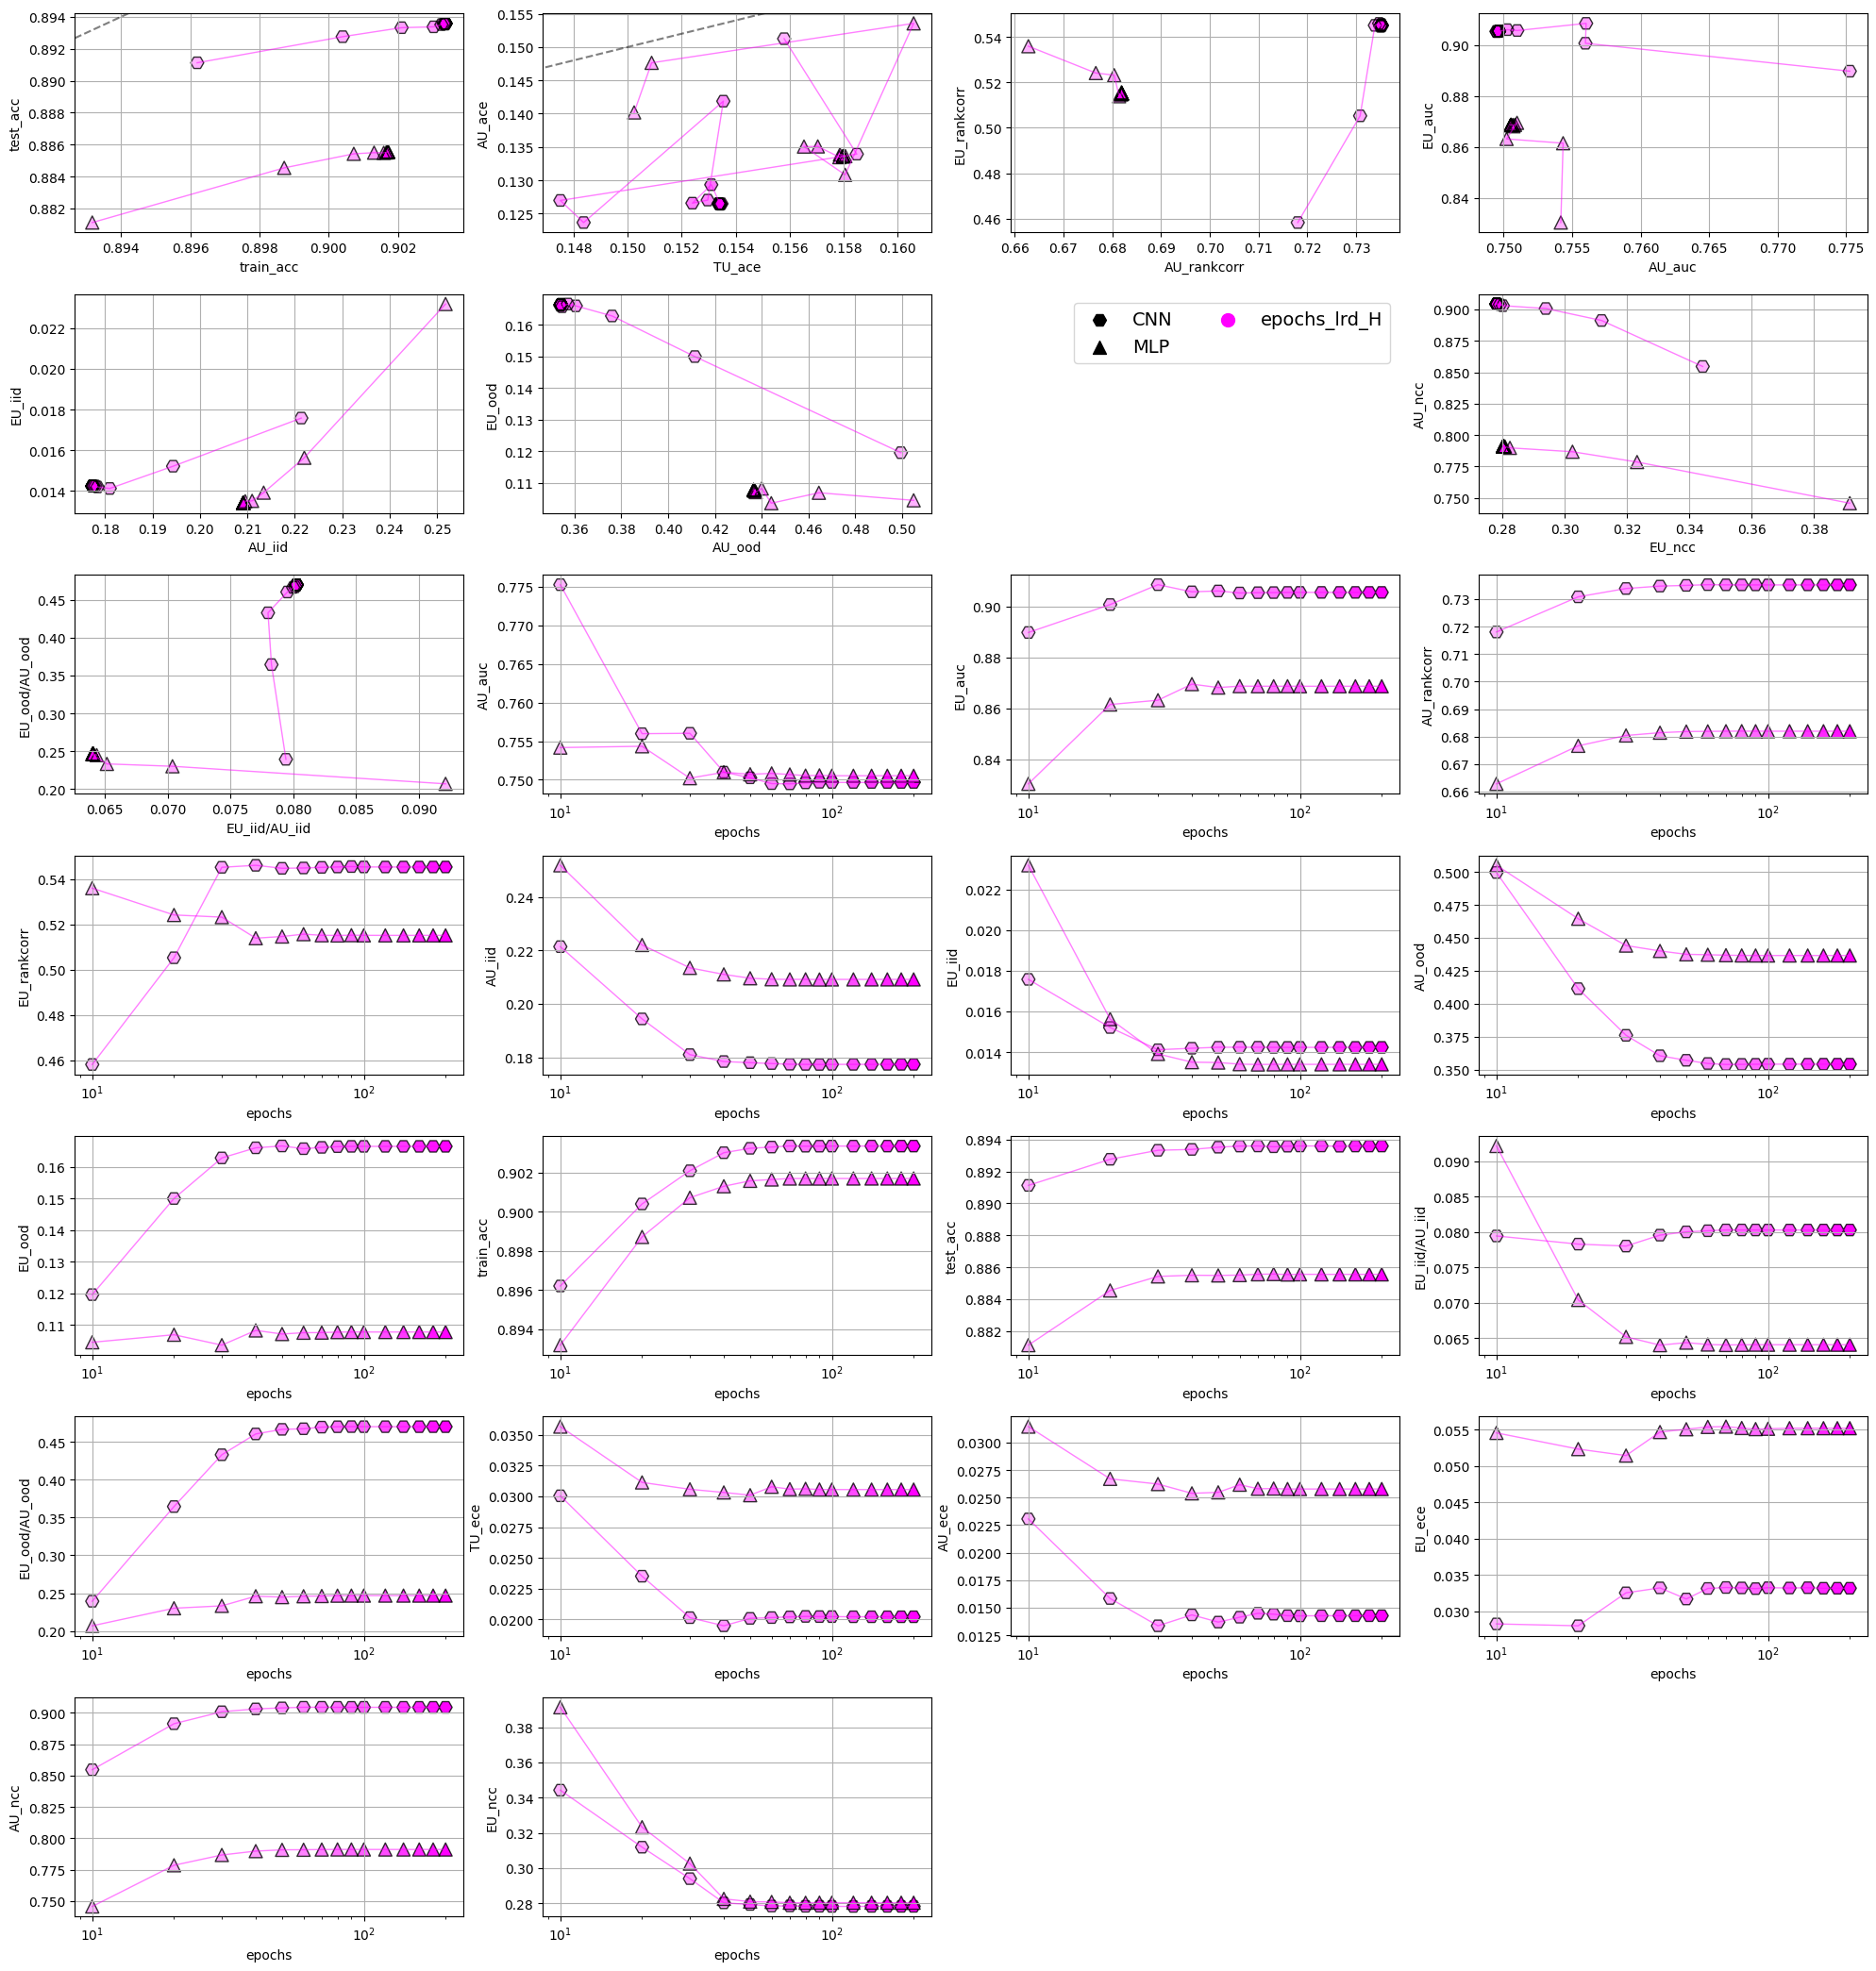

In [40]:
#old scatter matrix
include_seq_types =  ["epochs_lrd_H"]#df.seq_type.unique().tolist()
connect_sequences = True
seq_variable = "epochs"

#include_seq_types = uq_seq_types
default_options = {"logx": False, "logy": False, "add_x=y": False, "is_legend": False}
scatters = [["train_acc","test_acc", {"add_x=y": True}],    
            ["TU_ace", "AU_ace", {"add_x=y": True}],
            ["AU_rankcorr","EU_rankcorr", {"add_x=y": True}],
            ["AU_auc","EU_auc", {"add_x=y": True}],
            ["AU_iid","EU_iid", {"add_x=y": True}],
            
            ["AU_ood","EU_ood", {"add_x=y": True}],
            ["","", {"is_legend": True}],
            ["EU_ncc","AU_ncc", {"add_x=y": True}],
            ["EU_iid/AU_iid","EU_ood/AU_ood", {"add_x=y": True}]
            ]


comp_vars = ["AU_auc","EU_auc","AU_rankcorr","EU_rankcorr","AU_iid","EU_iid","AU_ood",
             "EU_ood","train_acc","test_acc","EU_iid/AU_iid","EU_ood/AU_ood",
             "TU_ece", "AU_ece", "EU_ece", "AU_ncc", "EU_ncc"]

for k in comp_vars:
    scatters.append([seq_variable, k, {"logx": 1,"logy": k in ["params"]}])

include_model_startswith = ["CNN","MLP"]
uq_seq_types = sorted(df["seq_type"].unique().tolist())

symbols = ['H', '^', "P","X", 'o', 'v', 's', 'D', '*']
cols2 = ["#006d77",  # deep teal
    "#daa520",  # goldenrod
    "#f08080",  # light coral
    "#4682b4",  # steel blue
    "#ba55d3",  # medium orchid
    "#2e8b57"  # sea green
]

#cols = ["C7", "C6", "C2", "C3", "C1", "C0", "C8", "C9", "C4", "C5"]+cols2
#strong dark colors
cols = ["blue", "red", "purple", "olive", "magenta", "brown", "cyan", "orange", "green", "gray"]+cols2
subplots = (7,4)
assert len(scatters) <= subplots[0]*subplots[1], "Too many subplots for grid, add more rows/cols"
fig, axs = plt.subplots(subplots[0], subplots[1], figsize=(5*subplots[1],3*subplots[0]))
for i,(x_key,y_key,options) in enumerate(scatters):
    ax = axs[i//subplots[1], i%subplots[1]] if subplots[0]>1 else axs[i%subplots[1]]
    if options.get("is_legend", default_options["is_legend"]):
        handles = []
        for j,model in enumerate(include_model_startswith):
            handles.append(ax.scatter([], [], color='k', marker=symbols[j], s=100, label=model))
        for k,seq in enumerate(uq_seq_types):
            if seq in include_seq_types:
                handles.append(ax.scatter([], [], color=cols[k], marker='o', s=100, label=seq))
        ax.legend(handles=handles, ncol=2, fontsize=14)
        ax.axis('off')
        continue

    for j,model in enumerate(include_model_startswith):
        for k,seq in enumerate(uq_seq_types):
            if seq not in include_seq_types:
                continue
            
            mask = np.array(df["seq_type"] == seq) & np.array([item.startswith(model) for item in df["model_cfg"]])
            if np.sum(mask) == 0:
                continue
            
            seq_param = df[mask]["varying_param"].iloc[0]
            
            if connect_sequences:
                x = df.loc[mask, x_key]
                y = df.loc[mask, y_key]
                v = df.loc[mask, seq_param]
                sort_idx = np.argsort(v)
                x = x.iloc[sort_idx]
                y = y.iloc[sort_idx]
                ax.plot(x,y, color=cols[k], alpha=0.5, linewidth=1)
            max_varying = df.loc[mask, seq_param].max()
            min_varying = df.loc[mask, seq_param].min()
            strength = 0.3 + 0.7 * (df.loc[mask, seq_param] - min_varying) / (max_varying - min_varying + 1e-8)
            ax.scatter(df.loc[mask, x_key], df.loc[mask, y_key],
                    color=cols[k], marker=symbols[j], s=100, alpha=strength, edgecolor="none")
            ax.scatter(df.loc[mask, x_key], df.loc[mask, y_key],
                color="none", marker=symbols[j], s=100, alpha=0.8, edgecolor="k")
    ax.set_xlabel(x_key)
    ax.set_ylabel(y_key)
    ax.grid()
    #get current axis bounds
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    l1,l2 = min(x0,y0), max(x1,y1)
    if x_key == y_key:
        ax.plot([l1,l2],[l1,l2], 'k--', alpha=0.5)
        ax.set_xlim(l1,l2), ax.set_ylim(l1,l2)
    if options.get("logx", default_options["logx"]):
        ax.set_xscale('log')
    if options.get("logy", default_options["logy"]):
        ax.set_yscale('log')
    if options.get("add_x=y", default_options["add_x=y"]):
        x1,x2,y1,y2 = ax.get_xlim()[0], ax.get_xlim()[1], ax.get_ylim()[0], ax.get_ylim()[1]
        l1,l2 = min(x1,y1), max(x2,y2)
        ax.plot([l1,l2],[l1,l2], 'k--', alpha=0.5)
        ax.set_xlim(x1,x2), ax.set_ylim(y1,y2)
for i in range(len(scatters), subplots[0]*subplots[1]):
    ax = axs[i//subplots[1], i%subplots[1]] if subplots[0]>1 else axs[i%subplots[1]]
    ax.axis('off')
plt.tight_layout()

In [21]:
df.keys()

Index(['unc_cfg', 'model_cfg', 'model_setup', 'seq_type', 'varying_param',
       'train_acc', 'test_acc', 'params', 'EU_auc', 'AU_auc', 'TU_auc',
       'EU_iid', 'EU_ood', 'AU_iid', 'AU_ood', 'TU_iid', 'TU_ood',
       'TU_rankcorr', 'EU_rankcorr', 'AU_rankcorr', 'mean_AU', 'mean_EU',
       'mean_TU', 'TU_ece', 'AU_ece', 'EU_ece', 'TU_ace', 'AU_ace', 'EU_ace',
       'TU_ncc', 'AU_ncc', 'EU_ncc', 'sep_majority', 'sep_soft',
       'EU_iid/AU_iid', 'EU_ood/AU_ood', 'depth', 'channels', 'batch_size',
       'lr_decay', 'model', 'epochs', 'also_save_ema_ckpts', 'data_aug',
       'model_args'],
      dtype='object')

In [41]:
uq_seq_types = sorted(df["seq_type"].unique().tolist())
table = pd.DataFrame(columns=["seq_type",
                              "train_acc", "test_acc",
                            "AU_rankcorr", "EU_auc", "-TU_ece",
                            "(AU-EU)_rankcorr", "(AU-EU)_ncc","(EU-AU)_auc", "(min(AU,EU)-TU)_ece", "(min(AU,EU)-TU)_ace", "(sep)_soft"])
# each value is a dictionary with {"CNN": [perf[seq1], perf[seq2], ...], "MLP": [...]}
seq_to_vpm = {}
def get_vals(row):
    direct_keys = ["seq_type",  "train_acc", "test_acc", "AU_rankcorr", "EU_auc"]
    out = {k: row[k] for k in direct_keys}
    out["-TU_ece"] = -row["TU_ece"]
    out["(AU-EU)_rankcorr"] = row["AU_rankcorr"] - row["EU_rankcorr"]
    out["(AU-EU)_ncc"] = row["AU_ncc"] - row["EU_ncc"]
    out["(EU-AU)_auc"] = row["EU_auc"] - row["AU_auc"]
    out["(min(AU,EU)-TU)_ece"] = min(row["AU_ece"], row["EU_ece"]) - row["TU_ece"]
    out["(min(AU,EU)-TU)_ace"] = min(row["AU_ace"], row["EU_ace"]) - row["TU_ace"]
    out["(sep)_soft"] = row["sep_soft"]
    return out

for seq in uq_seq_types:
    df_seq = df[df["seq_type"] == seq]
    val_dict = {}
    for model in ["CNN", "MLP"]:
        df_seq_model = df_seq[[item.startswith(model) for item in df_seq["model_cfg"]]]
        assert len(df_seq_model["varying_param"].unique()) == 1, f"Multiple varying params in {seq}, {model}. Found: {set(df_seq_model['varying_param'])}"
        if len(df_seq_model) == 0:
            raise ValueError(f"No models found for seq {seq} and model {model}")
        #sort table by varying param
        vpm = df_seq_model["varying_param"].iloc[0]
        df_seq_model = df_seq_model.sort_values(by=vpm)
        seq_to_vpm[seq] = df_seq_model[vpm].tolist()
        for row in df_seq_model.itertuples():
            for k,v in get_vals(row._asdict()).items():
                if k not in val_dict:
                    val_dict[k] = {}
                if model not in val_dict[k]:
                    val_dict[k][model] = []
                val_dict[k][model].append(v)
          
    #reduce all dicts with one unique value in all model keys to that value
    for k in val_dict:
        if len(set(sum([val_dict[k][m] for m in val_dict[k]],[]))) == 1:
            val_dict[k] = val_dict[k][list(val_dict[k].keys())[0]][0]
    val_dict["seq_type"] = seq
    table.loc[len(table)] = val_dict

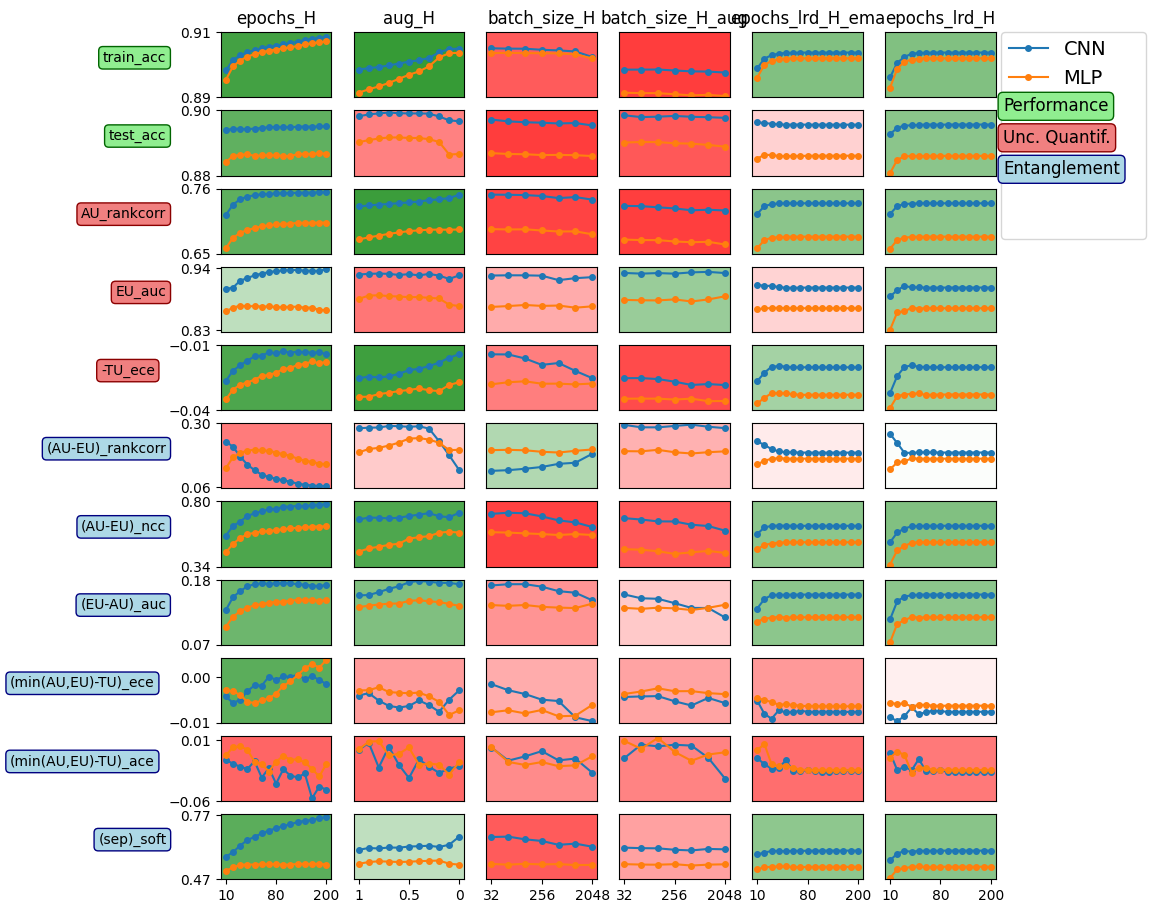

In [42]:
seq_types_use = ["aug_H","epochs_H","wd_H","depth","channels"]
seq_types_use = ["aug_H","epochs_H","epochs_H_aug","wd_H","wd_H_aug","depth","channels"]
seq_types_use = ["epochs_H","aug_H","batch_size_H","batch_size_H_aug","epochs_lrd_H_ema","epochs_lrd_H"]
#seq_types_use = uq_seq_types

metrics_use = ["train_acc", "test_acc",'AU_rankcorr', 'EU_auc', '-TU_ece',
       '(AU-EU)_rankcorr', '(AU-EU)_ncc', '(EU-AU)_auc', '(min(AU,EU)-TU)_ece',
       '(min(AU,EU)-TU)_ace', "(sep)_soft"]
models_use = ["CNN", "MLP"]
overlay_corr_alpha = 0.8
reverse_x_seq = ["wd_H", "wd_H_aug", "aug_H", "aug_H_EU"]

n_cols = len(seq_types_use)
n_rows = len(metrics_use)
figsize = 10
fig, axs = plt.subplots(n_rows, n_cols, figsize=(figsize,0.6*figsize/n_cols*n_rows))
num_xticks = 3
ignore_max_wd = True

def bbox_from_type(label_type):
    return dict(
            #   light version of edgecolor
                facecolor={"ent": "lightblue", "uq": "lightcoral", "perf": "lightgreen"}.get(label_type, "lightgray"),  # background color
                edgecolor={"ent": "navy", "uq": "darkred", "perf": "darkgreen"}.get(label_type, "gray"),  # border color
                boxstyle="round,pad=0.3"  # rounded box style
            )

#create a red-white-green diverging colormap from scratch
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list("red_white_green", ["red", "white", "green"])
CORR = []
for i,seq in enumerate(seq_types_use):
    row = table[table["seq_type"] == seq]
    CORR.append([])
    for j,metric in enumerate(metrics_use):
        ax = axs[j,i]
        d = row[metric].values[0]
        if metric.startswith("("):
            metric_type = "ent"
        elif "_acc" in metric:
            metric_type = "perf"
        else:
            metric_type = "uq"


        corr = 0
        for model in models_use:
            if model not in d.keys():
                continue
            y = d[model]
            x = list(range(len(y)))
            if seq.startswith("wd") and ignore_max_wd:
                #ignore last point
                x = x[:-1]
                y = y[:-1]
            if seq in reverse_x_seq:
                x = x[::-1]
            corr += (1/len(models_use))*np.corrcoef(x,y)[0,1] if len(x)>1 else 1.0
            ax.plot(x,y, marker='o', label=model, markersize=4, alpha=1)
        CORR[-1].append(corr)
        if j==0:
            ax.set_title(seq)
        if j == n_rows-1:
            xvar = seq_to_vpm[seq]
            if ignore_max_wd and seq.startswith("wd"):
                xvar = xvar[:-1]

            xtick_indices = np.linspace(0, len(xvar)-1, num=min(num_xticks, len(xvar)), dtype=int)
            
            if seq in reverse_x_seq:
                xtick_indices2 = (len(xvar)-1) - xtick_indices
            else:
                xtick_indices2 = xtick_indices
            x_tick_labels = [f"{xvar[idx]}" for idx in xtick_indices]
            ax.set_xticks(xtick_indices2)
            ax.set_xticklabels(x_tick_labels)
        else:
            axs[j,i].set_xticks([])
        if i == 0:
            ax.set_ylabel(metric, rotation=0, labelpad=10, ha='right', bbox=bbox_from_type(metric_type))
#go through all y axis and normalize such that each row uses the same, then set the ticks on the leftmost plot
for j in range(n_rows):
    min_y = min([axs[j,i].get_ylim()[0] for i in range(n_cols)])
    max_y = max([axs[j,i].get_ylim()[1] for i in range(n_cols)])
    for i in range(n_cols):
        axs[j,i].set_ylim(min_y, max_y)
        if i == 0:
            axs[j,i].set_yticks([float(f"{v:.2f}") for v in [min_y, max_y]])
        else:
            axs[j,i].set_yticks([])

if overlay_corr_alpha>0:
    #get red - white - green color such that -1 is red, 0 is white, 1 is green
    # set axis background color to corr_color with alpha overlay_corr_alpha
    for i in range(n_cols):
        for j in range(n_rows):
            corr_color = cmap((CORR[i][j]+1)/2)
            corr_color = (corr_color[0], corr_color[1], corr_color[2], overlay_corr_alpha)
            axs[j,i].set_facecolor(corr_color)

#add new legend axis in the top right corner
for i in range(5):
    axs[0,-1].plot([], [], color='k', label="            ", alpha=0)
lgnd = axs[0,-1].legend(fontsize=14,bbox_to_anchor=(1.05, 1.0), borderaxespad=0.)

#add text boxes to the y labels indicating type of metric (ent, uq, perf) Use absolute coords
#text_x,text_y = 0.91,0.8
lgnd_window = lgnd.get_window_extent(renderer = fig.canvas.get_renderer()).transformed(fig.transFigure.inverted())
delta = (lgnd_window.y1 - lgnd_window.y0)/7*2*1.1
text_x = axs[-1,-1].get_position().x1+delta/8
text_y = lgnd_window.y1-delta
for k,label_type, label in zip(range(3),["perf", "uq", "ent"], ["Performance", "Unc. Quantif.", "Entanglement"]):
    plt.text(text_x,text_y-0.035*k*9/len(metrics_use), label, transform=fig.transFigure, fontsize=12, va='top', ha='left',
            bbox=bbox_from_type(label_type))
#plt.tight_layout()



In [55]:
p = "/home/jloch/Desktop/diff/luzern/random_experiments/mnist/saves/AU2_EU__CNN_test_aug0_e1_(2of10).pth"
data = torch.load(p, weights_only=False)
len(data["checkpoints"])
for ckpt in data["checkpoints"]:
    #print sum of all squares of all weights
    total = 0
    for k,v in ckpt.items():
        total += abs(v**6).sum().item()
    print(total**0.5)

32.03449220987763
32.04966945600634


In [58]:
2.5*10

25.0

In [134]:
min_val = 10
max_val = 1000
# do squared spacing
t = np.linspace(min_val/max_val,1,30)
vals = (min_val + (max_val - min_val) * t**2).astype(int).tolist()
print(vals)

[10, 11, 16, 22, 31, 42, 55, 71, 89, 109, 132, 157, 184, 213, 245, 279, 316, 355, 396, 439, 485, 533, 583, 635, 690, 748, 807, 869, 933, 1000]


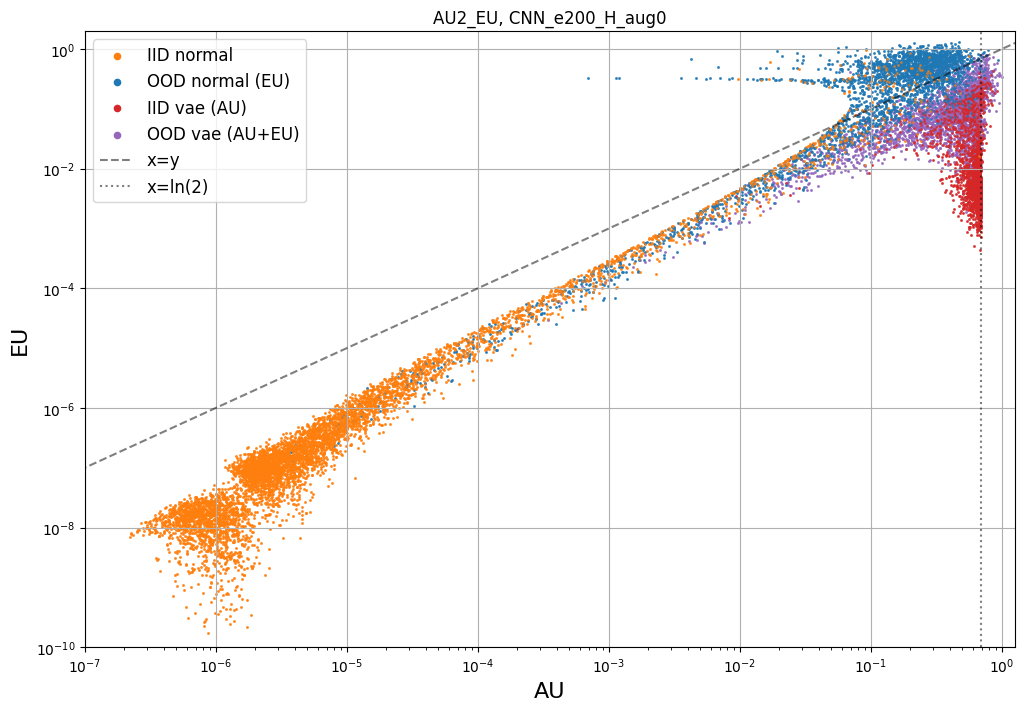

In [115]:


def unc_spread_plot(unc_stats, digit_colors=True, EU_bounds=None, AU_bounds=None, alpha=0.6, title=""):
    """
    Does a scatter plot of AU vs EU for all test points.
    Colors points by their labels C0-C9 and if they are part of the vae set they are black
    """
    
    plt.figure(figsize=(12,8))
    iid_mask = unc_stats["eval"]["iid_mask"]
    vae_mask = unc_stats["eval"]["vae_mask"]
    things_to_plot = {"col": [],
                      "x": [],
                      "y": [],
                      "label": []}
    AU = unc_stats["eval"]["unc"]["AU"]
    EU = unc_stats["eval"]["unc"]["EU"]
    if digit_colors:
        for digit in range(10):
            mask = unc_stats["eval"]["gts"] == digit
            mask = np.where(~vae_mask)[0][mask]
            col = f"C{digit}"
            things_to_plot["col"].append(col)
            things_to_plot["x"].append(AU[mask])
            things_to_plot["y"].append(EU[mask])
            things_to_plot["label"].append(f"{digit}")
        mask = np.where(vae_mask & iid_mask)[0]
        col = 'k'
        things_to_plot["col"].append(col)
        things_to_plot["x"].append(AU[mask])
        things_to_plot["y"].append(EU[mask])
        things_to_plot["label"].append("IID vae")
        mask = np.where(vae_mask & ~iid_mask)[0]
        col = 'gray'
        things_to_plot["col"].append(col)
        things_to_plot["x"].append(AU[mask])
        things_to_plot["y"].append(EU[mask])
        things_to_plot["label"].append("OOD vae")
    else:
        masks = [np.where(~vae_mask & iid_mask)[0],
                 np.where(~vae_mask & ~iid_mask)[0],
                 np.where(vae_mask & iid_mask)[0],
                 np.where(vae_mask & ~iid_mask)[0]]
        cols = ["C1", "C0", "C3", "C4"]
        labels = ["IID normal", "OOD normal (EU)", "IID vae (AU)", "OOD vae (AU+EU)"]
        for mask,col,label in zip(masks,cols,labels):
            things_to_plot["col"].append(col)
            things_to_plot["x"].append(AU[mask])
            things_to_plot["y"].append(EU[mask])
            things_to_plot["label"].append(label)

    for col,x,y,label in zip(things_to_plot["col"], things_to_plot["x"], things_to_plot["y"], things_to_plot["label"]):
        plt.scatter(x, y, color=col, s=1, alpha=alpha)
        plt.scatter([], [], label=label, color=col, s=20, alpha=1.0)
    for col,x,y,label in zip(things_to_plot["col"][::-1], things_to_plot["x"][::-1], things_to_plot["y"][::-1], things_to_plot["label"][::-1]):
        #inverse loop order to make alpha-values cleaner
        plt.scatter(x, y, color=col, s=1, alpha=alpha)
    if AU_bounds is not None:
        plt.xlim(10**AU_bounds[0], 10**AU_bounds[1])
    if EU_bounds is not None:
        plt.ylim(10**EU_bounds[0], 10**EU_bounds[1])
    """if digit_colors:
        for digit in range(10):
            #simulated legend for visibility
            plt.scatter([], [], label=f"{digit}", s=20, alpha=1.0, color=f"C{digit}")
    else:
        plt.scatter([], [], label="IID normal (No Unc)", color='C1', s=20, alpha=1.0)
        plt.scatter([], [], label="OOD normal (EU)", color='C0', s=20, alpha=1.0)
    c_iid_vae = 'k' if digit_colors else 'C3'
    c_ood_vae = 'gray' if digit_colors else 'C4'
    #plot black for iid vae points and grey for ood vae points
    mask = np.where(vae_mask & iid_mask)[0]
    plt.scatter(AU[mask], EU[mask], color=c_iid_vae, s=1, alpha=0.6)
    mask = np.where(vae_mask & ~iid_mask)[0]
    plt.scatter(AU[mask], EU[mask], color=c_ood_vae, s=1, alpha=0.6)"""
    
    plt.xscale('log') 
    plt.yscale('log')
    plt.xlabel("AU", fontsize=16)
    plt.ylabel("EU", fontsize=16)
    plt.title(title)
    xmin,xmax = plt.gca().get_xlim()
    ymin,ymax = plt.gca().get_ylim()
    l1,l2 = min(xmin,ymin), max(xmax,ymax)
    plt.plot([l1,l2],[l1,l2], 'k--', alpha=0.5, label="x=y")
    log2 = np.log(2)
    plt.plot([log2,log2],[l1,l2], 'k:', alpha=0.5, label="x=ln(2)")
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    plt.legend(ncols=1+int(digit_colors), fontsize=12)
    plt.grid()

f = "/home/jloch/Desktop/diff/luzern/random_experiments/mnist/saves/epochs_H/AU2_EU__CNN_e200_H_aug0.pth"
data = torch.load(f, weights_only=False)

unc_cfg,model_cfg = f.split("/")[-1].replace(".pth","").split("__")

#EU_bounds = (-8,0.3)#(-5.5,0.1)#(-4,0.1)
#AU_bounds = (-5.5,0.1)#(-3,0.4)#
unc_spread_plot(data["unc_stats"], digit_colors=False, EU_bounds=EU_bounds, AU_bounds=AU_bounds, alpha=0.6, 
                title=f"{unc_cfg}, {model_cfg}")

In [110]:
unc_stats = mu.uncertainty_stats_from_ckpts(data,include_test=False,add_stats=True)

Processing models:   0%|          | 0/10 [00:00<?, ?it/s]

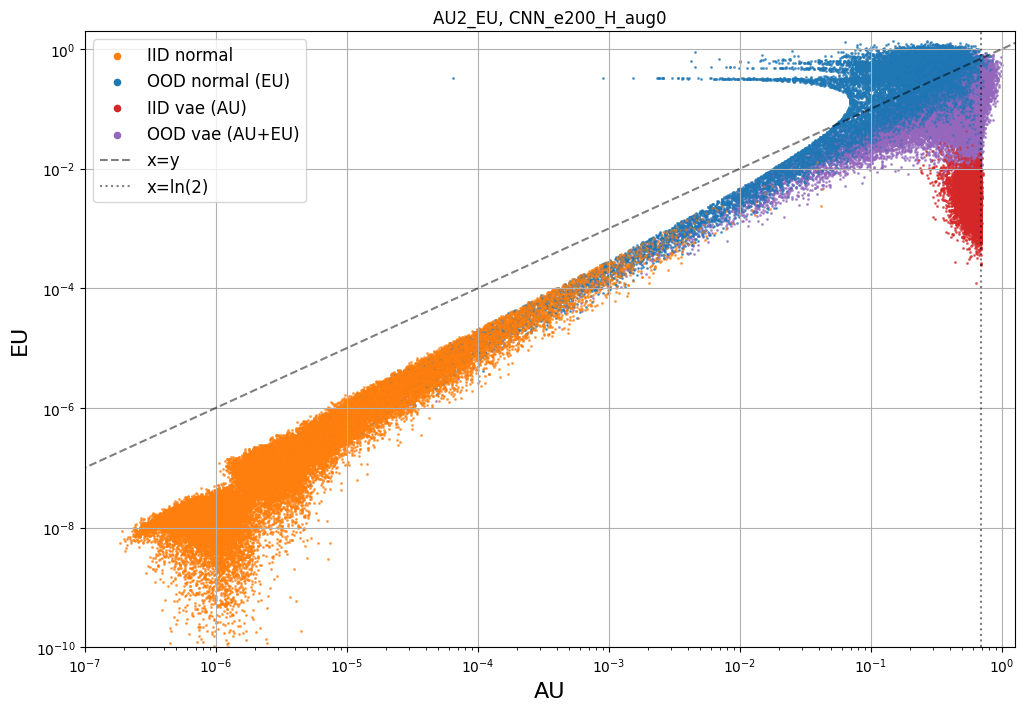

In [114]:
EU_bounds = (-10,0.3)#(-5.5,0.1)#(-4,0.1)
AU_bounds = (-7,0.1)#(-3,0.4)#
unc_spread_plot(unc_stats, digit_colors=False, EU_bounds=EU_bounds, AU_bounds=AU_bounds, alpha=0.4, 
                title=f"{unc_cfg}, {model_cfg}")

In [99]:
data.keys()

dict_keys(['checkpoints', 'histories', 'final_acc', 'uncertainty_setup', 'model_setup', 'unc_stats'])

## train

experiments:

1. epoch based sweeps. Heavy model with epochs [10,20, ..., 200], aug=[0,0.25,0.5,0.75,1]
    1. No lr decay ema/normal
    2. lr_mult_per_epoch=0.9 ema/normal
2. batch_size sweep [4,8,16,32,64,128,256,512,1024,2048] for heavy models aug=[0,1]
3. continuation of epoch_H_aug0 and epoch_H_aug1 for epochs in [120,140, ... 200]

In [79]:
#model = mu.get_models_dict(tsne=0)["MLP0"]()
model = mu.str_to_class["CNNDeluxe"](**{"base_channels": 32, "num_blocks": 3, "num_downsamples": 3})
train_dl, val_dl = mu.get_dataloaders(ignore_digits=[2,3,5], augment=False, batch_size=8192, ambiguous_vae_samples=0, num_workers=4)
history = mu.train(model, train_dl, val_dl, epochs=100, lr=1e-4, weight_decay=0.0, cosine_anneal_epochs=0, 
                   soft_labels=False, ckpt_every_epochs=10, also_save_ema_ckpts=1, epoch_ema_memory=1,
                   lr_mult_per_epoch=0.9)

Training:   0%|          | 0/600 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 196.00 MiB. GPU 0 has a total capacity of 23.51 GiB of which 209.88 MiB is free. Process 3008585 has 2.60 GiB memory in use. Including non-PyTorch memory, this process has 19.66 GiB memory in use. Of the allocated memory 18.94 GiB is allocated by PyTorch, and 267.36 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

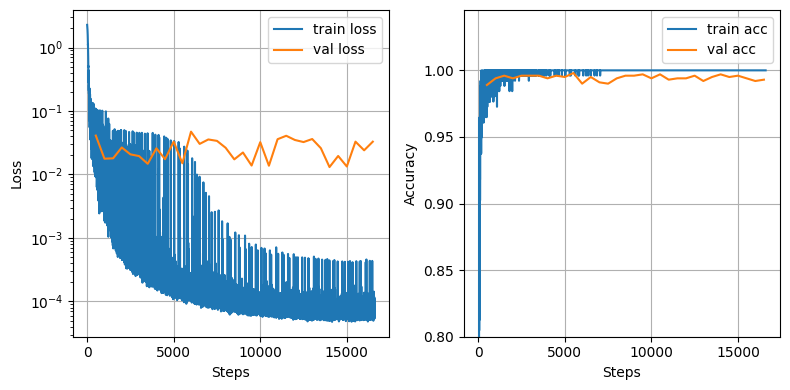

In [71]:
mu.loss_plot(history)

In [56]:
for epoch,state_dict in history["ckpt_epochs"].items():
    #print squared sum of params
    print(sum([torch.sum(param**2).item() for param in state_dict.values() if len(param.shape)>1]))
for epoch,state_dict in history["ema_ckpt_epochs"].items():
    #print squared sum of params
    print(sum([torch.sum(param**2).item() for param in state_dict.values() if len(param.shape)>1]))

119.12598609924316
123.51023864746094
126.97553253173828
130.23082542419434
117.79608917236328
122.63883686065674
126.2640609741211
129.59331512451172


## qualitative plots for one model

{'TU': {'ace': 0.14160805177465657,
  'ece': 0.015270802937569054,
  'a': np.float64(-6.615888266856349),
  'b': np.float64(-4.885783803186728)},
 'AU': {'ace': 0.12201524296434714,
  'ece': 0.013398891289293658,
  'a': np.float64(-6.84947150834984),
  'b': np.float64(-4.840487085543963)},
 'EU': {'ace': 0.29038834414633496,
  'ece': 0.03574652782986745,
  'a': np.float64(-9.350974733913624),
  'b': np.float64(-2.3129565156682204)}}

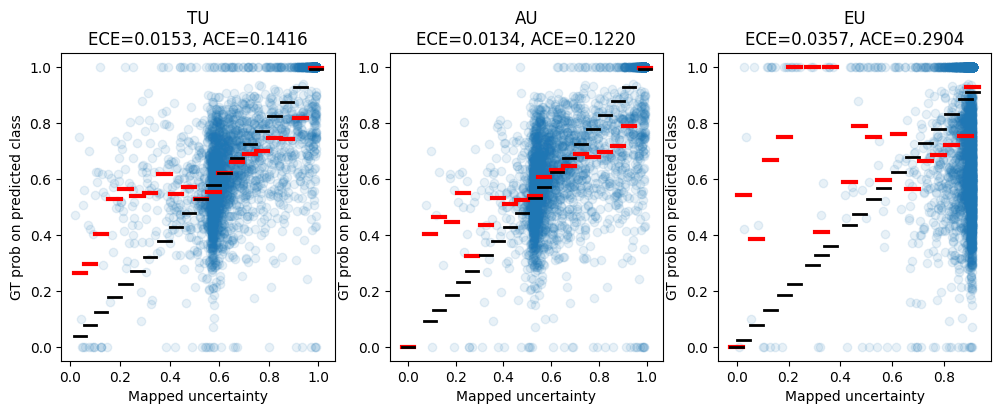

In [38]:

data = torch.load("/home/jloch/Desktop/diff/luzern/random_experiments/mnist/saves/aug_H/AU2_EU__CNN_aug0_H.pth", weights_only=False)
mu.calib_stats_values(out_dict=data["unc_stats"], do_plot=True)

{'TU': {'spearman_all': np.float64(0.742950759519819),
  'spearman_high': np.float64(0.11155108244600243),
  'spearman_low': np.float64(0.643751788835952),
  'ncc_all': np.float64(0.9329566205478227),
  'mean_entropies': {'gt': np.float32(0.15919748),
   'all': np.float32(0.17732683),
   'high': np.float32(0.6760726),
   'low': np.float32(0.121917106)}},
 'AU': {'spearman_all': np.float64(0.7487667440520835),
  'spearman_high': np.float64(0.12396745561357903),
  'spearman_low': np.float64(0.6489526822516904),
  'ncc_all': np.float64(0.9488921449759464),
  'mean_entropies': {'gt': np.float32(0.15919748),
   'all': np.float32(0.16590472),
   'high': np.float32(0.6499978),
   'low': np.float32(0.112122886)}},
 'EU': {'spearman_all': np.float64(0.6253280394716236),
  'spearman_high': np.float64(0.0027847169506995282),
  'spearman_low': np.float64(0.5532176588066268),
  'ncc_all': np.float64(0.23149470884878576),
  'mean_entropies': {'gt': np.float32(0.15919748),
   'all': np.float32(0.0114

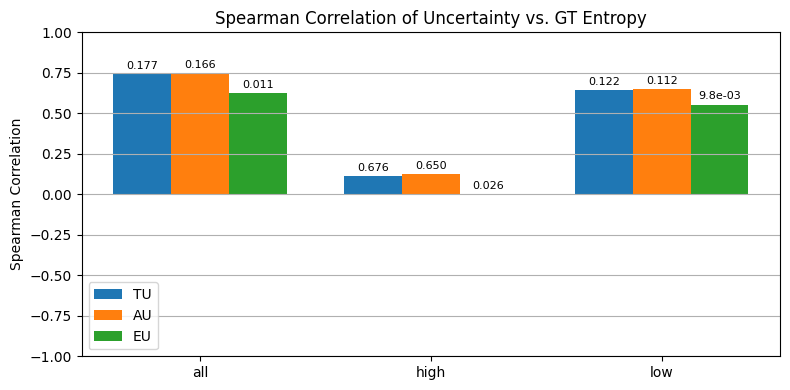

In [39]:
mu.ambiguity_stats(out_dict=data["unc_stats"], do_plot=True)

{'TU': {'auc': np.float64(0.8108158770205544),
  'ood_entropy': tensor(0.4976),
  'iid_entropy': tensor(0.1773)},
 'AU': {'auc': np.float64(0.7541650222823759),
  'ood_entropy': tensor(0.3135),
  'iid_entropy': tensor(0.1659)},
 'EU': {'auc': np.float64(0.9273970912107548),
  'ood_entropy': tensor(0.1840),
  'iid_entropy': tensor(0.0114)}}

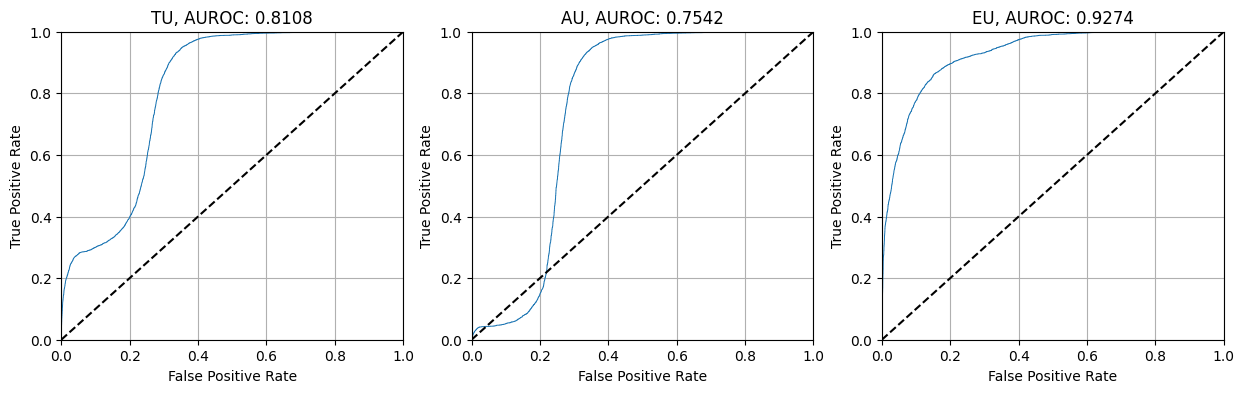

In [40]:
mu.ood_stats(out_dict=data["unc_stats"], do_plot=True)

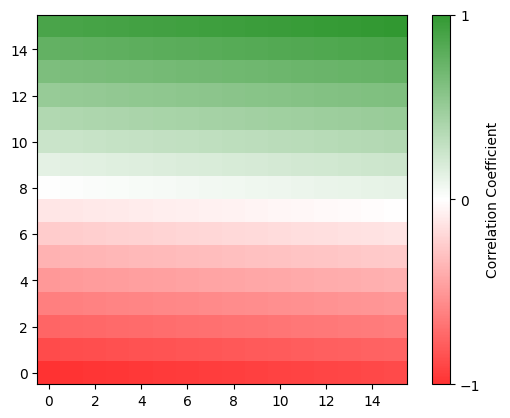

In [87]:
cmap = LinearSegmentedColormap.from_list("red_white_green", ["red", "white", "green"])
#get matrix of colors
overlay_corr_alpha = 0.8
i1,i2 = 0.5-overlay_corr_alpha/2,0.5+overlay_corr_alpha/2
colors = np.linspace(i1,i2,256).reshape(16,16)
cmap2 = LinearSegmentedColormap.from_list("red_white_green", [cmap(i1), "white", cmap(i2)])
plt.imshow(np.linspace(-1,1,256).reshape(16,16), cmap=cmap2, origin="lower")
plt.colorbar(ticks=[-1,0,1], label="Correlation Coefficient")


In [38]:
files = Path("/home/jloch/Desktop/diff/luzern/random_experiments/mnist/saves").rglob("epochs_lrd_H*/*.pth")
# loop through all pth files in the folder Replace data["model_setup"]["epochs"] with the value in e.g. AU2_EU__CNN_aug0_H_lrd0.9_e20.pth
for f in files:
    epoch = int(f.stem.replace("_ema","").split("_e")[-1])
    data = torch.load(f, weights_only=False)
    data["model_setup"]["epochs"] = epoch
    torch.save(data, f)


## functional form of AU and EU

Text(0, 0.5, 'Total Uncertainty')

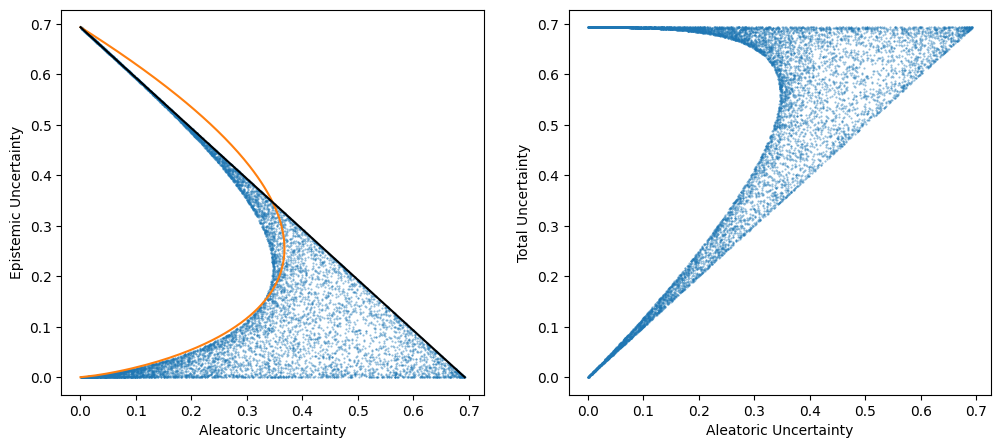

In [178]:
def entropy(probs,dim=0):
    return -torch.sum(probs * torch.log(probs + 1e-8), dim=dim)

def uncertainties(probs):
    """
    Computes aleatoric, epistemic and total uncertainty from a set of probability predictions.
    probs: tensor of shape (num_ensemble, num_samples, num_classes)
    returns: aleatoric, epistemic, total uncertainty of shape (num_samples,)
    """
    # aleatoric uncertainty: mean entropy
    aleatoric = entropy(probs, dim=2).mean(dim=0)
    # total uncertainty: entropy of mean
    mean_probs = probs.mean(dim=0)
    total = entropy(mean_probs, dim=1)
    # epistemic uncertainty: total - aleatoric
    epistemic = total - aleatoric
    return aleatoric, epistemic, total

num_classes = 2
num_samples = 10000
num_ensemble = 2

logit_std = 15
corr = 0.8

if corr>0:
    logits = (torch.randn(num_ensemble, num_samples, 1)*logit_std*corr + 
              torch.randn(num_ensemble, num_samples, num_classes)*logit_std*(1-corr))
else:
    logits = torch.randn(num_ensemble, num_samples, num_classes)*logit_std
probs = torch.softmax(logits, dim=2)

aleatoric, epistemic, total = uncertainties(probs)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(aleatoric.numpy(), epistemic.numpy(), '.', markersize=1, alpha=0.5)
t = np.linspace(1e-8, 1, 200)
y = -np.log(t)*t
plt.plot(y,t*max_tu)
plt.xlabel("Aleatoric Uncertainty")
plt.ylabel("Epistemic Uncertainty")

max_tu = np.log(num_classes)

plt.plot(np.linspace(0,max_tu,100),np.linspace(max_tu,0,100), 'k-', label="log(n_c)")
#plt.xscale('log')
#plt.yscale('log')

plt.subplot(1,2,2)
plt.plot(aleatoric.numpy(), total.numpy(), '.',  markersize=1, alpha=0.5)
plt.xlabel("Aleatoric Uncertainty")
plt.ylabel("Total Uncertainty")

In [212]:
probs.shape

(2, 0, 2)

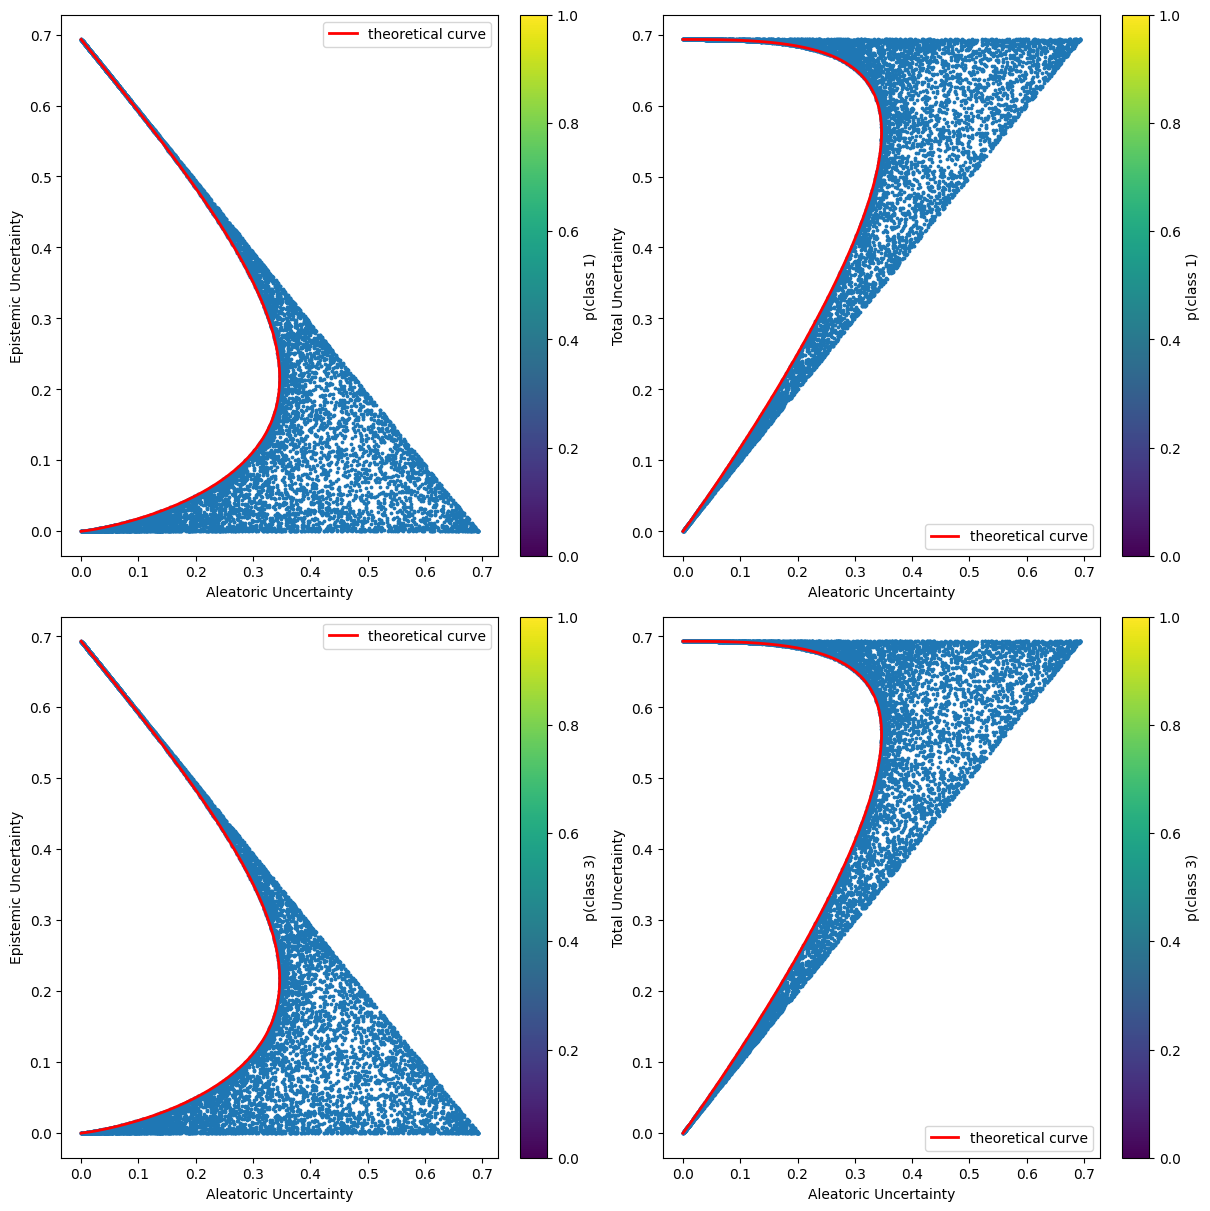

In [ ]:
num_classes = 2
num_samples_per_dim = 100
num_ensemble = 2

eps = 1e-5
axis_probs = np.linspace(eps,1-eps,num_samples_per_dim)
p1,p3 = np.meshgrid(axis_probs, axis_probs)
p2 = 1-p1
p4 = 1-p3
probs12 = np.stack([p1,p2], axis=2).reshape(-1,2)
probs34 = np.stack([p3,p4], axis=2).reshape(-1,2)
probs = np.stack([probs12, probs34], axis=0)
mask = sum([(p1+p3)<=1, (p1+p4)<=1])==2
probs = probs[:,mask.flatten()]
#redefine p1,p3
p1 = probs[0,:,0]
p3 = probs[1,:,0]
aleatoric, epistemic, total = uncertainties(torch.asarray(probs))
#to numpy
aleatoric, epistemic, total = aleatoric.numpy(), epistemic.numpy(), total.numpy()

plot_theo_curves = True
highlight_mask = None#np.logical_and(p1<2*eps,True)
s = 3
a = 1.0
fig, axs = plt.subplots(2, 2, figsize=(12, 12), constrained_layout=True)

# 1,1
sc = axs[0,0].scatter(aleatoric, epistemic, c=p1.flatten(), cmap='viridis', s=s, alpha=a)
axs[0,0].set_xlabel("Aleatoric Uncertainty"); axs[0,0].set_ylabel("Epistemic Uncertainty")
fig.colorbar(sc, ax=axs[0,0], label="p(class 1)")

# 1,2
sc = axs[0,1].scatter(aleatoric, total, c=p1.flatten(), cmap='viridis', s=s, alpha=a)
axs[0,1].set_xlabel("Aleatoric Uncertainty"); axs[0,1].set_ylabel("Total Uncertainty")
fig.colorbar(sc, ax=axs[0,1], label="p(class 1)")

# 2,1
sc = axs[1,0].scatter(aleatoric, epistemic, c=p3.flatten(), cmap='inferno', s=s, alpha=a)
axs[1,0].set_xlabel("Aleatoric Uncertainty"); axs[1,0].set_ylabel("Epistemic Uncertainty")
fig.colorbar(sc, ax=axs[1,0], label="p(class 3)")

# 2,2
sc = axs[1,1].scatter(aleatoric, total, c=p3.flatten(), cmap='inferno', s=s, alpha=a)
axs[1,1].set_xlabel("Aleatoric Uncertainty"); axs[1,1].set_ylabel("Total Uncertainty")
fig.colorbar(sc, ax=axs[1,1], label="p(class 3)")


S = np.linspace(eps,1-eps,200)
TU = -np.log(S/2)*(S/2)+ -np.log(1-S/2)*(1-S/2)
AU = (-np.log(S)*S - np.log(1-S)*(1-S))/2
EU = TU - AU
# highlights — always plot onto the same axes objects
for ax, yvals in [(axs[0,0], "epistemic"),
                    (axs[0,1], "total"),
                    (axs[1,0], "epistemic"),
                    (axs[1,1], "total")]:
    
    if highlight_mask is not None and np.any(highlight_mask):
        y_vals = epistemic if yvals == "epistemic" else total
        ax.scatter(
            aleatoric[highlight_mask], yvals[highlight_mask],
            facecolors='none', edgecolors='k', linewidths=1.0,
            s=s*10, alpha=0.7, zorder=5
        )
    if plot_theo_curves:
        y_vals = EU if yvals == "epistemic" else TU
        ax.plot(AU, y_vals, 'r-', linewidth=2, label="theoretical curve")
        ax.legend()


plt.show()


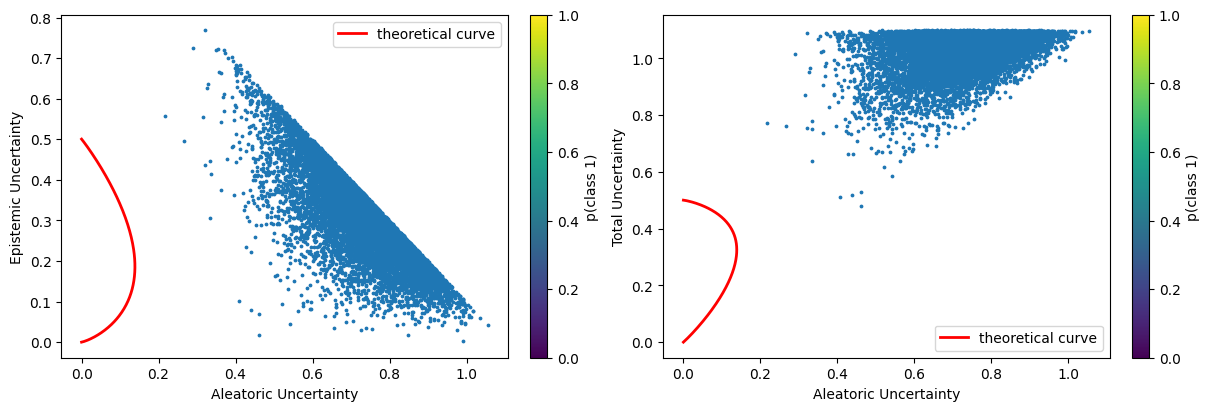

In [269]:
num_classes = 3
num_samples = 10000
num_ensemble = 5

eps = 1e-5
logit_std = 1.5
corr = 0.0

if corr>0:
    logits = (torch.randn(num_ensemble, num_samples, 1)*logit_std*corr + 
              torch.randn(num_ensemble, num_samples, num_classes)*logit_std*(1-corr))
else:
    logits = torch.randn(num_ensemble, num_samples, num_classes)*logit_std
probs = torch.softmax(logits, dim=2)

aleatoric, epistemic, total = uncertainties(probs)
aleatoric, epistemic, total = uncertainties(torch.asarray(probs))
#to numpy
aleatoric, epistemic, total = aleatoric.numpy(), epistemic.numpy(), total.numpy()

plot_theo_curves = True
highlight_mask = None#np.logical_and(p1<2*eps,True)
s = 3
a = 1.0
fig, axs = plt.subplots(1,2, figsize=(12, 4), constrained_layout=True)

# 1,1
sc = axs[0].scatter(aleatoric, epistemic, s=s, alpha=a)
axs[0].set_xlabel("Aleatoric Uncertainty"); axs[0].set_ylabel("Epistemic Uncertainty")
fig.colorbar(sc, ax=axs[0], label="p(class 1)")

# 1,2
sc = axs[1].scatter(aleatoric, total, s=s, alpha=a)
axs[1].set_xlabel("Aleatoric Uncertainty"); axs[1].set_ylabel("Total Uncertainty")
fig.colorbar(sc, ax=axs[1], label="p(class 1)")


S = np.linspace(eps,1-eps,200)
c = num_ensemble
TU = -np.log(S/c)*(S/c)+ -np.log(1-S/c)*(1-S/c)
AU = (-np.log(S)*S - np.log(1-S)*(1-S))/c
EU = TU - AU
# highlights — always plot onto the same axes objects
for ax, yvals in [(axs[0], "epistemic"),
                    (axs[1], "total")]:
    
    if highlight_mask is not None and np.any(highlight_mask):
        y_vals = epistemic if yvals == "epistemic" else total
        ax.scatter(
            aleatoric[highlight_mask], yvals[highlight_mask],
            facecolors='none', edgecolors='k', linewidths=1.0,
            s=s*10, alpha=0.7, zorder=5
        )
    if plot_theo_curves:
        y_vals = EU if yvals == "epistemic" else TU
        ax.plot(AU, y_vals, 'r-', linewidth=2, label="theoretical curve")
        ax.legend()


plt.show()


In [97]:
np.log(2)

np.float64(0.6931471805599453)

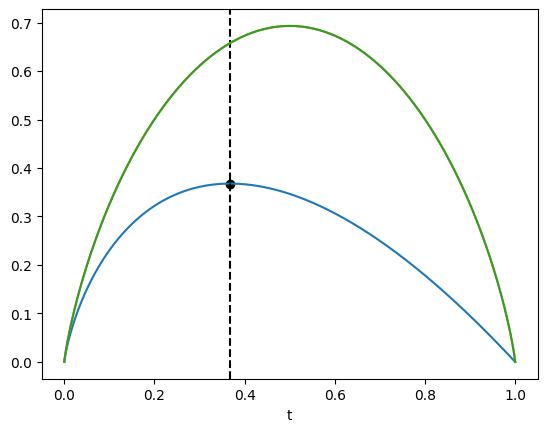

In [89]:
t = np.linspace(0,1,1000)
plt.plot(t,-t*np.log(t+1e-8), label="1 class entropy")
plt.axvline(1/np.e, color='k', linestyle='--', label="t=1/e")
plt.xlabel("t")
#plot point at (1/e, 1/e)
plt.scatter(1/np.e, 1/np.e*np.log(np.e), color='k')
y = -t*np.log(t+1e-8)-(1-t)*np.log((1-t)+1e-8)
plt.plot(t,y, label="2 class entropy")
plt.plot(t,y[::-1])

In [91]:
-0.5*np.log(0.5)*2

np.float64(0.6931471805599453)

In [75]:
print(torch.round(probs[:,epistemic.argmax(),:],decimals=4))

tensor([[0., 1.],
        [1., 0.],
        [1., 0.]])
